In [1]:
import os, sys
!bash install_rapids.sh
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base
import os
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_validate
#import cudf, cuml
from sklearn.compose import ColumnTransformer
from h2o.estimators.targetencoder import H2OTargetEncoderEstimator


kf = StratifiedKFold(5, random_state=0, shuffle=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rapids/rapids.0.14.0
/kaggle/input/rapids/rapids.0.15.0
/kaggle/input/cat-in-the-dat/test.csv
/kaggle/input/cat-in-the-dat/sample_submission.csv
/kaggle/input/cat-in-the-dat/train.csv


In [2]:
train = pd.read_csv("/kaggle/input/cat-in-the-dat/train.csv", index_col='id')
test =  pd.read_csv("/kaggle/input/cat-in-the-dat/test.csv", index_col='id')
submission = pd.read_csv("/kaggle/input/cat-in-the-dat/sample_submission.csv", index_col='id')

In [3]:
def chi_2_and_cramers_v(contingency_df):
    """
    perform chi-square and cramer's V
        H0: feature and target are independent
        H1: feature and target are not independent
    """
    from scipy import stats
    chi2, p, dof, expected = stats.chi2_contingency(contingency_df)
    n = contingency_df.sum().sum()
    r, k = contingency_df.shape
    cramers_v = np.sqrt(chi2 / (n * min((r-1), (k-1))))
    return chi2, p, cramers_v

def describe_data(train_df, test_df, confidence_value=0.95):
    # train_df = train_df.drop("id", axis=1)
    # test_df = test_df.drop("id", axis=1)
    feat_property_list = []
    columns = [col for col in train_df.columns if not col == 'target']
    for col in columns:
        feat_description = {}
        contingency_df = pd.crosstab(train_df[col], train_df['target'], margins=False)
        chi2, p, cramers_v = chi_2_and_cramers_v(contingency_df)
                
        feat_description['feature'] = col
        #feat_description['chi_2'] = chi2
        feat_description['chi_2_p_value'] = p
        if p < (1- confidence_value):
            feat_description['feat-dependence'] = "dependent"
        else:
            feat_description['feat-dependence'] = "independent"
            
        

        feat_description['cramers_v'] = cramers_v
                
        feat_description['train_cardinality'] = train_df[col].nunique()
        feat_description['test_cardinality'] = test_df[col].nunique()
        feat_description['in_train_not_in_test'] = len(set(train_df[col]) - set(test_df[col]))
        feat_description['in_test_not_in_train'] = len(set(test_df[col]) - set(train_df[col]))
        # feat_description['cardinality_diff(test-train)'] = feat_description['test_cardinality'] - feat_description['train_cardinality']
        feat_description['biggest-cat(train)%'] = 100 * train[col].value_counts(normalize = True, dropna = False).values[0]
        feat_description['dtype'] = train_df[col].dtype

        feat_property_list.append(feat_description)
        
    return pd.DataFrame(feat_property_list).round(3)


In [11]:
data_description = describe_data(train, test)

In [12]:
data_description.sort_values("cramers_v")

,feature,chi_2_p_value,feat-dependence,cramers_v,train_cardinality,test_cardinality,in_train_not_in_test,in_test_not_in_train,biggest-cat(train)%,dtype
0,bin_0,0.234,independent,0.002,2,2,2,2,87.250,object
3,bin_3,0.000,dependent,0.007,2,2,0,0,51.178,object
2,bin_2,0.000,dependent,0.012,2,2,2,2,61.678,object
4,bin_4,0.000,dependent,0.046,2,2,0,0,63.878,object
7,nom_2,0.000,dependent,0.067,6,6,0,0,33.765,object
21,day,0.000,dependent,0.068,7,7,0,0,24.772,int64
6,nom_1,0.000,dependent,0.070,6,6,0,0,33.727,object
8,nom_3,0.000,dependent,0.072,6,6,0,0,33.708,object
9,nom_4,0.000,dependent,0.088,4,4,0,0,30.764,object
1,bin_1,0.000,dependent,0.089,2,2,2,2,74.339,object


In [4]:
def plt_count_and_target(train_df, features, sortby='count', h=20, w=20, pad=8, tm_max_range=100, max_features=15):
    import seaborn as sns
    feat_num = len(features)
    m = np.ceil((feat_num)/2.)
    fig, axes = plt.subplots(int(m), 2, figsize=(w, h+(feat_num//2)*pad))
    fig.tight_layout(pad=pad)
    try:
        axes = axes.ravel()
    except AttributeError:
        axes = [axes]
    for feat in features:
        if train_df[feat].dtype != 'object':
            train_df[feat] = train_df[feat].astype(str)
    for idx, feat in enumerate(features):
        if idx < feat_num:
            ax1 = axes[idx]
            ax2 = ax1.twinx()
            dt1 = train.groupby(feat).agg({'target':'count'})
            dt2 = pd.crosstab(train[feat], train['target'], margins=True).sort_values('All', ascending=False).drop(index=['All'])
            dt2['target_mean'] = (dt2[1]*100)/dt2['All']
            if sortby == 'count':
                master_data = pd.merge(dt1, dt2, left_index=True, right_index=True).reset_index().sort_values('All', ascending=False)
            if sortby == 'target_mean':
                master_data = pd.merge(dt1, dt2, left_index=True, right_index=True).reset_index().sort_values('target_mean', ascending=False)

            master_data[feat] = master_data[feat].astype(str)
            if master_data.shape[0] > (max_features + 1):
                master_data = master_data.iloc[:max_features]
            sns.barplot(master_data[feat].tolist(), master_data['target'].tolist(), ax=ax1)
            ax2.plot(master_data[feat].tolist(), master_data['target_mean'].tolist(), '-ro')
            ax2.axhline((train.target.sum()*100)/train.shape[0], color='r', label='overall_target_mean')
            ax1.set_xlabel('feature')
            ax1.set_ylabel('count', )
            ax2.set_ylabel('target mean(%)',)
            ax1.set_title(f"{features[idx]}")
            ax1.xaxis.set_tick_params(rotation=90)
            # step_ = (int(master_data.target_mean.max() + 5) - int(master_data.target_mean.min()-5))//10
            #ax2.yaxis.set_ticks(np.arange(int(master_data.target_mean.min()-5), int(master_data.target_mean.max() + 5), step_))
            ax2.set_ylim(max(0, int(master_data.target_mean.min()-10)), int(master_data.target_mean.max() + 3),)

            plt.legend()
    plt.show()

## Binary

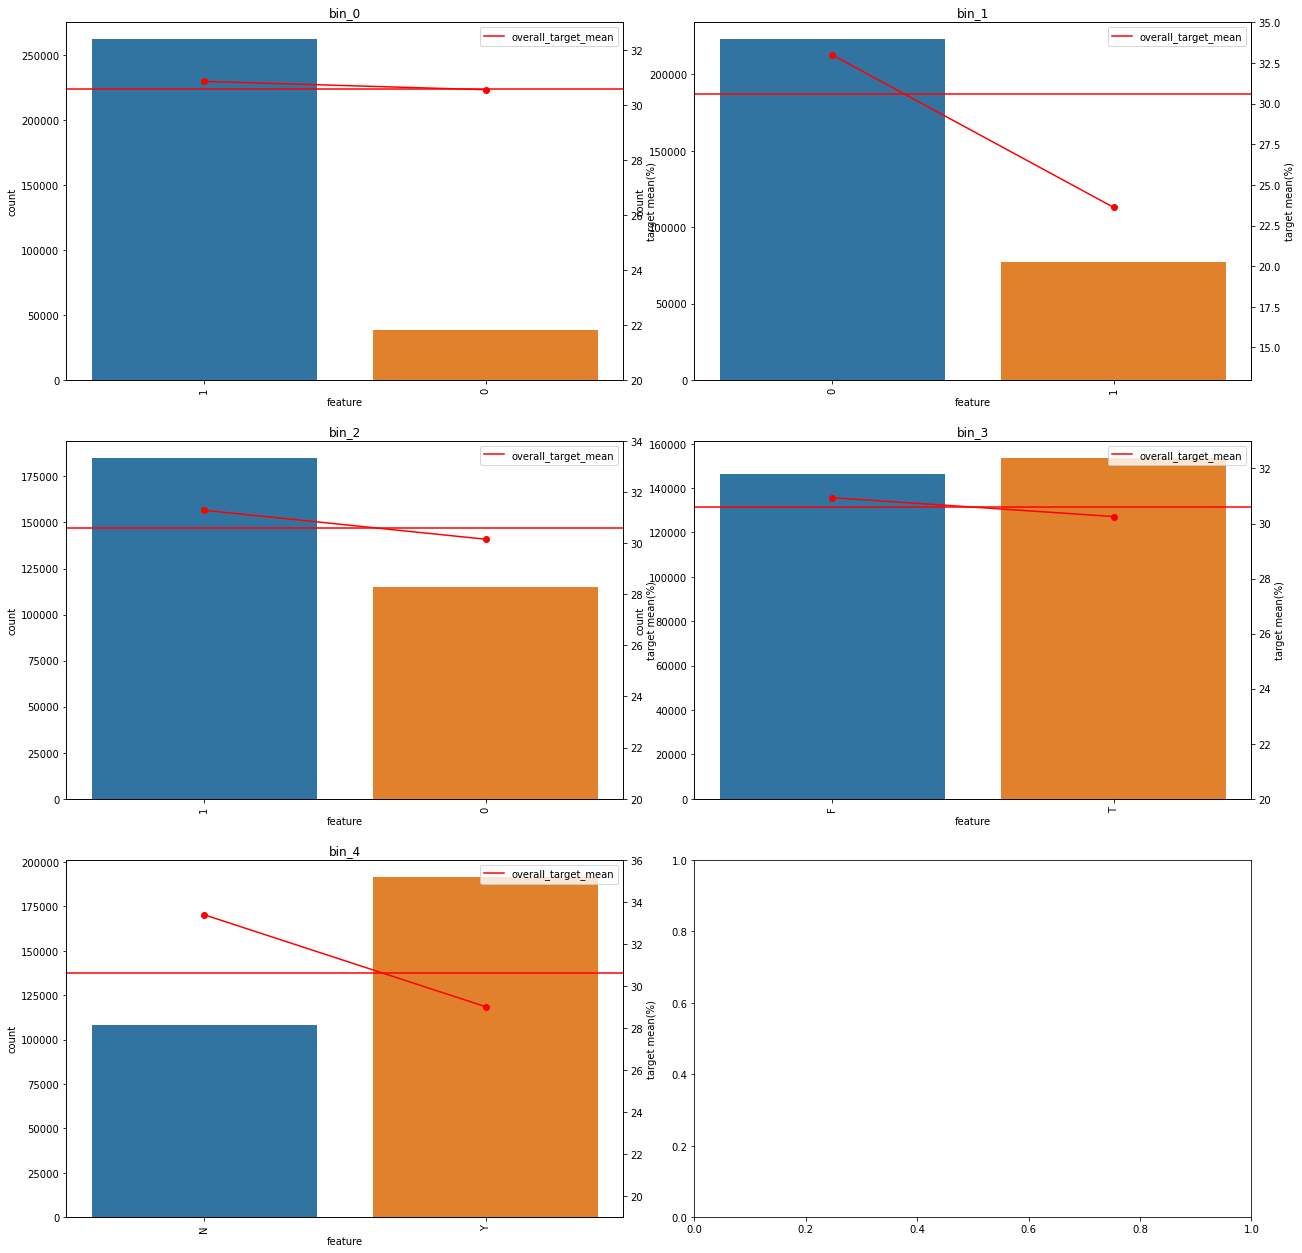

In [9]:
plt_count_and_target(train, features=[col for col in train.columns if col.startswith("bin")], sortby='target_mean', w=18, h=10, pad=4, tm_max_range=55)

## Ordinal Features

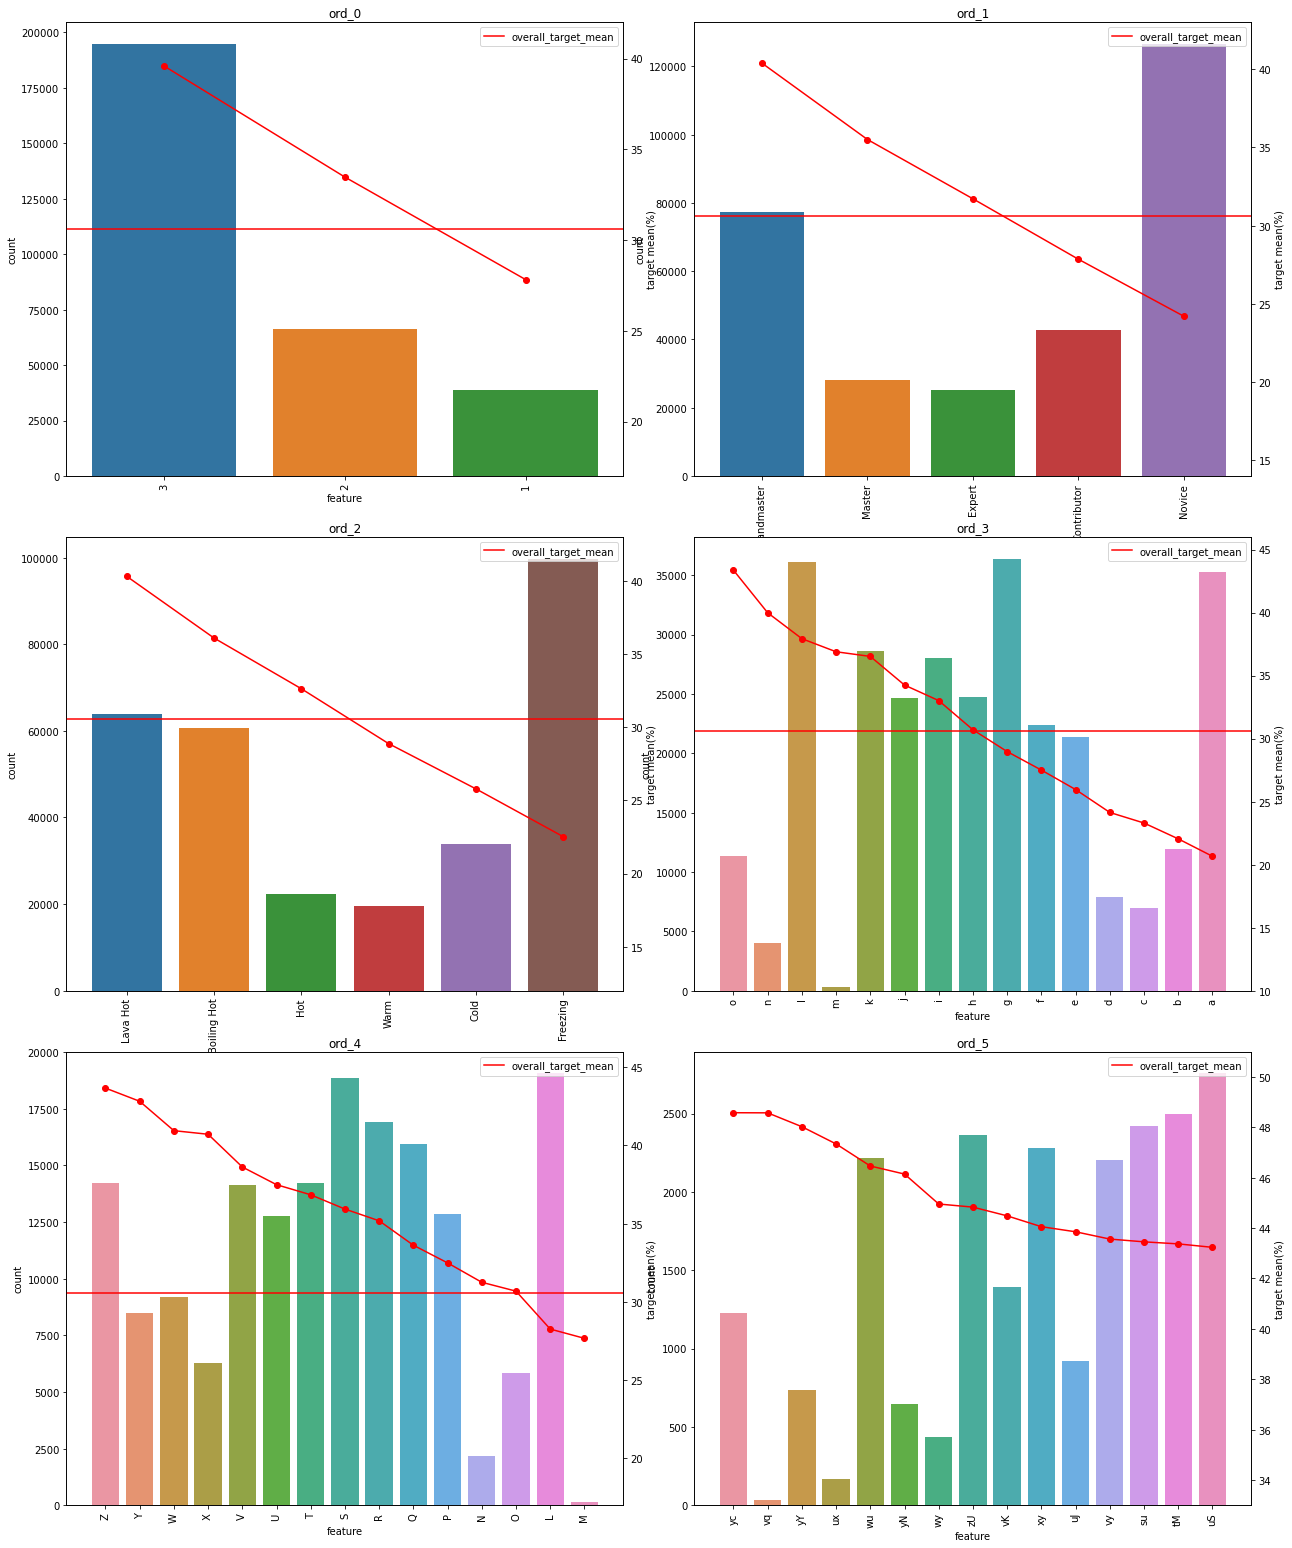

In [7]:
plt_count_and_target(train, features=[col for col in train.columns if col.startswith("ord")], sortby='target_mean', w=18, h=10, pad=4, tm_max_range=55)

## Nominal 

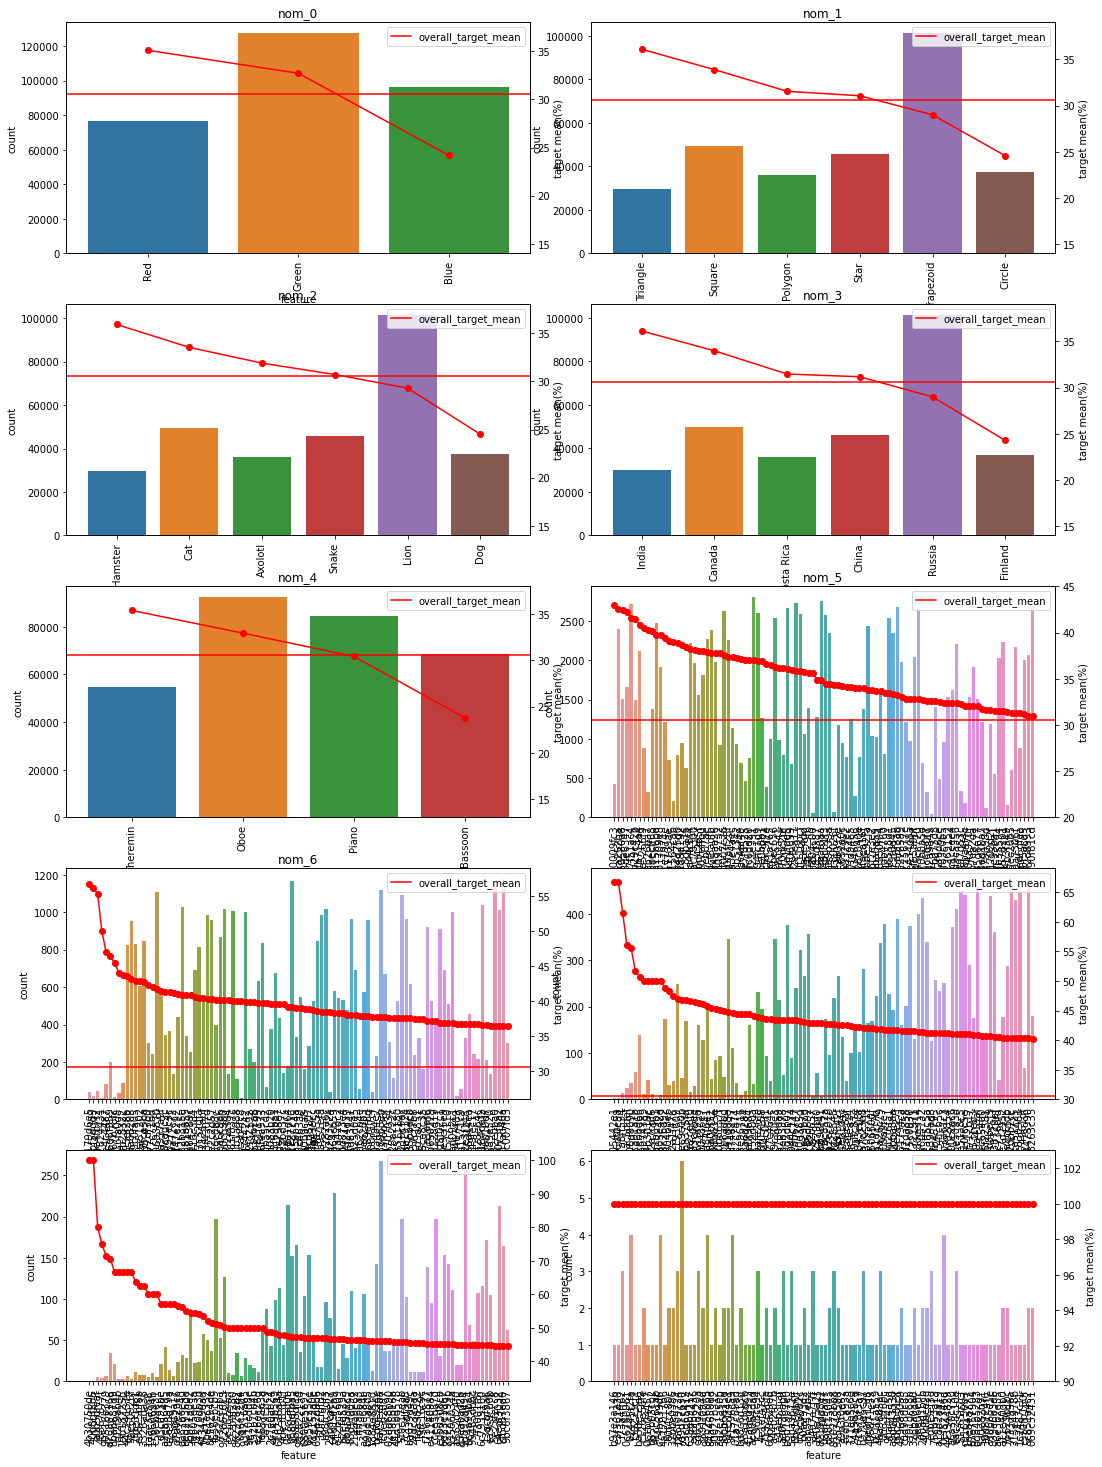

In [8]:
plt_count_and_target(train, features=[col for col in train.columns if col.startswith("nom")], sortby='target_mean', w=15, h=5, pad=3, tm_max_range=105, max_features=100)

## Cuml Model Trainig

In [2]:
import cuml, cudf, cupy
import pandas as pd

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_validate
#import cudf, cuml
from sklearn.compose import ColumnTransformer
from cuml.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from cuml.linear_model import LogisticRegression
from cuml_lr_with_targetencoding import OHEColumnTransform, TargetEncodeTransform
from config import Config
from custom_scoring_module import roc_auc_gpu
kf = StratifiedKFold(5, random_state=Config.RANDOM_STATE, shuffle=True)

In [14]:
train = cudf.read_csv("/kaggle/input/cat-in-the-dat/train.csv", index_col=None)
test =  cudf.read_csv("/kaggle/input/cat-in-the-dat/test.csv", index_col=None)
submission = cudf.read_csv("/kaggle/input/cat-in-the-dat/sample_submission.csv", index_col=None)

In [26]:
X = train.drop('target', axis=1)
y = train['target']

one_hot_columns = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 
            'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'day', 'month',
            'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']


pipe = make_pipeline(
    OHEColumnTransform(columns= one_hot_columns,
                 handle_unknown='ignore', sparse=False),
    TargetEncodeTransform(columns=['nom_5',]),
    TargetEncodeTransform(columns=['nom_6',]),
    TargetEncodeTransform(columns=['nom_7',]),
    TargetEncodeTransform(columns=['nom_8',]),
    TargetEncodeTransform(columns=['nom_9',]),
    TargetEncodeTransform(columns=['ord_0',]),
    # TargetEncodeTransform(columns=['ord_1',]),
    # TargetEncodeTransform(columns=['ord_2',]),
    # TargetEncodeTransform(columns=['ord_3',]),
    # TargetEncodeTransform(columns=['ord_4',]),
    # TargetEncodeTransform(columns=['ord_5',]),
    LogisticRegression(),
)


In [28]:
pipe.get_params()

{'memory': None,
 'steps': [('ohecolumntransform',
   OHEColumnTransform(columns=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
                               'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'day',
                               'month', 'ord_0', 'ord_1', 'ord_2', 'ord_3',
                               'ord_4', 'ord_5'])),
  ('targetencodetransform-1', TargetEncodeTransform(columns=['nom_5'])),
  ('targetencodetransform-2', TargetEncodeTransform(columns=['nom_6'])),
  ('targetencodetransform-3', TargetEncodeTransform(columns=['nom_7'])),
  ('targetencodetransform-4', TargetEncodeTransform(columns=['nom_8'])),
  ('targetencodetransform-5', TargetEncodeTransform(columns=['nom_9'])),
  ('targetencodetransform-6', TargetEncodeTransform(columns=['ord_0'])),
  ('logisticregression',
   LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, max_iter=1000, linesearch_max_iter=50, verbose=4, l1_ratio=None, solver='qn', handle=<cuml.common.handle.Handle object at 0x

In [27]:
import numpy as np
lr_params = {'logisticregression__C': np.random.uniform(0, 10, 1000)}
gs = RandomizedSearchCV(pipe, param_distributions=lr_params, cv=kf, 
                        verbose=6, scoring=make_scorer(roc_auc_gpu, greater_is_better=True), 
                        n_jobs=1, n_iter=100, random_state=0)
model = gs.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


TypeError: Implicit conversion to a host NumPy array via __array__ is not allowed, To explicitly construct a GPU array, consider using cupy.asarray(...)
To explicitly construct a host array, consider using .to_array()

In [23]:
from cuml.metrics import make_scorer

ImportError: cannot import name 'make_scorer' from 'cuml.metrics' (/opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/metrics/__init__.py)